In [1]:
import torch
import torch.nn as nn
from collections import OrderedDict
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.optim as optim
import torch.nn.utils as utils

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
X_valid = X_train[:10000,...]
y_valid = y_train[:10000]

X_train = X_train[10000:,...]
y_train = y_train[10000:]

In [5]:
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_valid_tensor = torch.from_numpy(X_valid)
y_valid_tensor = torch.from_numpy(y_valid)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)

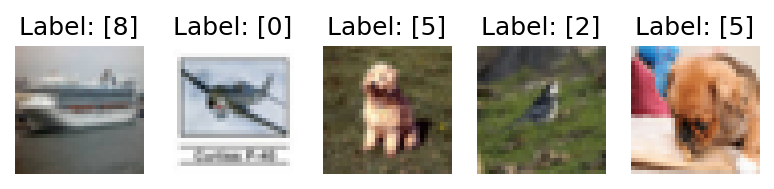

In [6]:
num_images_to_show = 5
random_indices = np.random.randint(0, len(X_train), num_images_to_show)
plt.figure(dpi=150)

# Plotting the images
for i, idx in enumerate(random_indices, 1):
    plt.subplot(1, num_images_to_show, i)
    plt.imshow(X_train[idx].squeeze(), cmap='gray')
    plt.title(f"Label: {y_train[idx]}")
    plt.axis('off')

plt.show()

In [7]:
class CustomCNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CustomCNN, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(3, 96, 3, 1, 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(3, 2),

            nn.Conv2d(96, 128, 3, 1, 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(3, 2),

            nn.Conv2d(128, 256, 3, 1, 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(3, 2),

            nn.Flatten(),
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(2048, 10),
        )

    def forward(self, x):
        return self.layers(x)



net = CustomCNN()

# Print the model architecture
print(net)


CustomCNN(
  (layers): Sequential(
    (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): Dropout(p=0.5, inplace=False)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (9): ReLU()
    (10): Dropout(p=0.5, inplace=False)
    (11): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=4096, out_features=2048, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=2048, out_features=2048, bias=True)
    (17): ReLU()
    (18): Dropout(p=0.5, inplace=False)
    (19): Linear(in_features=204

In [8]:
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available. Training on CPU.")


GPU is available.


In [9]:

net = net.to('cuda')


In [10]:
mu_X = X_train.mean()
sigma_X = X_train.std()

mu_y = y_train.mean()
sigma_y = y_train.std()

X_train = (X_train - mu_X) / sigma_X
X_valid = (X_valid - mu_X) / sigma_X
X_test = (X_test - mu_X) / sigma_X

#y_train = (y_train - mu_y) / sigma_y
#y_valid = (y_valid - mu_y) / sigma_y
#y_test = (y_test - mu_y) / sigma_y

In [11]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.5)

In [13]:
train_loss_list1 = list()
train_acc_list1 = list()
valid_loss_list1 = list()
valid_acc_list1 = list()

In [14]:
num_epochs = 600
seed = 42
torch.manual_seed(seed)

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.float()
        inputs = inputs.float().permute(0, 3, 1, 2)
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        labels = labels.squeeze()
        outputs = net(inputs)
        #predicted_classes = torch.argmax(outputs, dim=1).unsqueeze(1).float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = correct_train / total_train
    train_loss = running_loss / len(train_loader)

    # Validation Loop
    net.eval()
    running_loss_valid = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for inputs_valid, labels_valid in valid_loader:
            inputs_valid = inputs_valid.float()
            inputs_valid = inputs_valid.float().permute(0, 3, 1, 2)
            inputs_valid, labels_valid = inputs_valid.to('cuda'), labels_valid.to('cuda')
            outputs_valid = net(inputs_valid)
            labels_valid = labels_valid.squeeze()
            loss_valid = criterion(outputs_valid, labels_valid)
            running_loss_valid += loss_valid.item()

            _, predicted_valid = torch.max(outputs_valid.data, 1)
            total_valid += labels_valid.size(0)
            correct_valid += (predicted_valid == labels_valid).sum().item()

    valid_accuracy = correct_valid / total_valid
    valid_loss = running_loss_valid / len(valid_loader)

    train_loss_list1.append(train_loss)
    train_acc_list1.append(train_accuracy)
    valid_loss_list1.append(valid_loss)
    valid_acc_list1.append(valid_accuracy)

    if epoch%20==0:
        print(f'Epoch {epoch + 1}/{num_epochs}, ' +
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, ' +
              f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')

print('Finished Training')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/600, Train Loss: 2.5427, Train Acc: 0.1040, Valid Loss: 2.2996, Valid Acc: 0.1054
Epoch 21/600, Train Loss: 1.1007, Train Acc: 0.6119, Valid Loss: 1.7405, Valid Acc: 0.6395
Epoch 41/600, Train Loss: 0.7840, Train Acc: 0.7254, Valid Loss: 1.5404, Valid Acc: 0.7129
Epoch 61/600, Train Loss: 0.6079, Train Acc: 0.7850, Valid Loss: 1.3606, Valid Acc: 0.7484
Epoch 81/600, Train Loss: 0.4857, Train Acc: 0.8284, Valid Loss: 1.3212, Valid Acc: 0.7663
Epoch 101/600, Train Loss: 0.3950, Train Acc: 0.8591, Valid Loss: 1.1632, Valid Acc: 0.7692
Epoch 121/600, Train Loss: 0.3181, Train Acc: 0.8892, Valid Loss: 1.0949, Valid Acc: 0.8009
Epoch 141/600, Train Loss: 0.2556, Train Acc: 0.9092, Valid Loss: 1.0342, Valid Acc: 0.7954
Epoch 161/600, Train Loss: 0.2118, Train Acc: 0.9254, Valid Loss: 0.9863, Valid Acc: 0.7982
Epoch 181/600, Train Loss: 0.1742, Train Acc: 0.9388, Valid Loss: 0.9523, Valid Acc: 0.8040
Epoch 201/600, Train Loss: 0.1493, Train Acc: 0.9489, Valid Loss: 0.9060, Valid Acc: 0

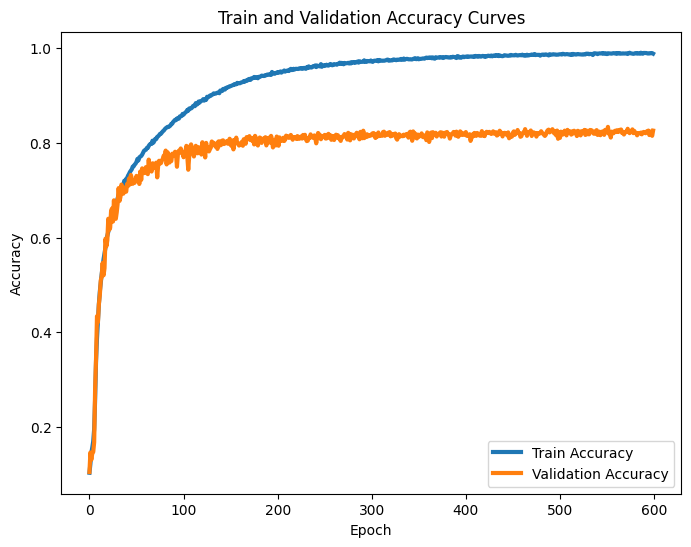

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(train_acc_list1, label='Train Accuracy', lw=3)
plt.plot(valid_acc_list1, label='Validation Accuracy', lw=3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy Curves')
plt.legend()
plt.show()

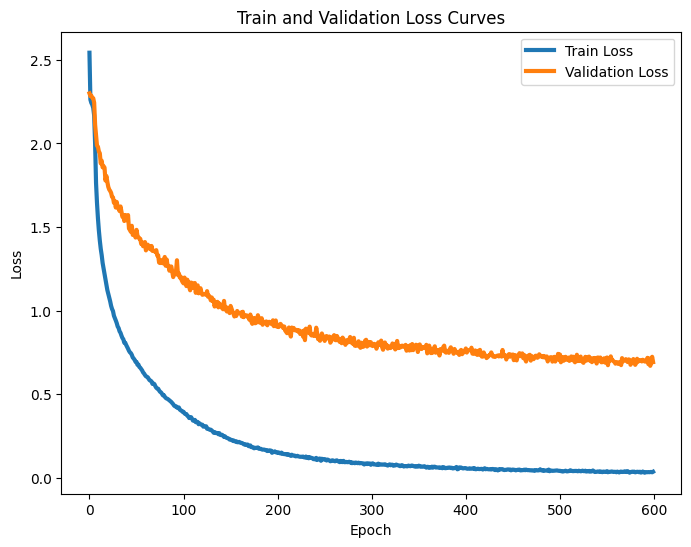

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(train_loss_list1, label='Train Loss', lw=3)
plt.plot(valid_loss_list1, label='Validation Loss', lw=3)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss Curves')
plt.legend()
plt.show()

In [17]:
net.eval()  # Set model to evaluation mode
running_loss_test = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():  # No gradient calculation
    for inputs_test, labels_test in test_loader:
        inputs_test = inputs_test.float().permute(0, 3, 1, 2)  # Convert and permute if necessary
        inputs_test, labels_test = inputs_test.to('cuda'), labels_test.to('cuda')  # Move to CUDA if using GPU
        labels_test = labels_test.squeeze()
        outputs_test = net(inputs_test)
        loss_test = criterion(outputs_test, labels_test)
        running_loss_test += loss_test.item()

        _, predicted_test = torch.max(outputs_test.data, 1)
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()

test_accuracy = correct_test / total_test
test_loss = running_loss_test / len(test_loader)

print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.4f}')


Test Loss: 0.7078, Test Acc: 0.8180
